# Klasyfikacja nowotworów na podstawie mutacji somatycznych i ekspresji RNA

In [15]:
import pandas as pd 
import re
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np


In [16]:
!pip install biopython pyranges

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 63.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 85.5 MB/s eta 0:00:00:00:0100:01


## Przygotowanie danych

In [17]:
!wget http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
!gunzip hg38.fa.gz

--2025-06-29 14:50:06--  http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘hg38.fa.gz’

hg38.fa.gz          100%[===================>] 938.09M  45.5MB/s    in 22s     

2025-06-29 14:50:28 (42.7 MB/s) - ‘hg38.fa.gz’ saved [983659424/983659424]



In [2]:
from google.cloud import bigquery
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


In [3]:
oncokb_df = pd.read_csv("/kaggle/input/gene-list-vogelstein/cancerGeneList.tsv", sep="\t")
oncokb_df
vogelstein_genes = oncokb_df[oncokb_df["Vogelstein"] == "Yes"]["Hugo Symbol"].unique().tolist()
vogelstein_genes

['ABL1',
 'AKT1',
 'ALK',
 'AMER1',
 'APC',
 'AR',
 'ARID1A',
 'ASXL1',
 'ATM',
 'ATRX',
 'AXIN1',
 'BAP1',
 'BCL2',
 'BCOR',
 'BRAF',
 'BRCA1',
 'BRCA2',
 'CARD11',
 'CBL',
 'CDC73',
 'CDH1',
 'CDKN2A',
 'CEBPA',
 'CIC',
 'CREBBP',
 'CTNNB1',
 'DAXX',
 'DNMT3A',
 'EGFR',
 'EP300',
 'ERBB2',
 'EZH2',
 'FBXW7',
 'FGFR2',
 'FGFR3',
 'FLT3',
 'FOXL2',
 'GATA3',
 'GNA11',
 'GNAQ',
 'GNAS',
 'HNF1A',
 'HRAS',
 'IDH1',
 'IDH2',
 'JAK1',
 'JAK2',
 'JAK3',
 'KDM5C',
 'KDM6A',
 'KIT',
 'KMT2D',
 'KRAS',
 'MAP2K1',
 'MAP3K1',
 'MED12',
 'MEN1',
 'MET',
 'MLH1',
 'MPL',
 'MSH2',
 'MSH6',
 'MYD88',
 'NF1',
 'NF2',
 'NFE2L2',
 'NOTCH1',
 'NOTCH2',
 'NPM1',
 'NRAS',
 'PAX5',
 'PBRM1',
 'PDGFRA',
 'PIK3CA',
 'PIK3R1',
 'PPP2R1A',
 'PRDM1',
 'PTCH1',
 'PTEN',
 'PTPN11',
 'RB1',
 'RET',
 'RNF43',
 'SETD2',
 'SF3B1',
 'SMAD2',
 'SMAD4',
 'SMARCA4',
 'SMARCB1',
 'SMO',
 'SOCS1',
 'SPOP',
 'STAG2',
 'STK11',
 'TET2',
 'TNFAIP3',
 'TP53',
 'TSC1',
 'U2AF1',
 'VHL',
 'WT1',
 'ARID2',
 'B2M',
 'CASP8',
 'CRL

In [35]:
query = """SELECT 
                case_barcode, 
                Hugo_Symbol, 
                Variant_Type, 
                Tumor_Seq_Allele1,
                Tumor_Seq_Allele2,
                Start_Position AS Start,
                End_Position,
                Chromosome,
                primary_site  
FROM
  `isb-cgc-bq.TCGA.masked_somatic_mutation_hg38_gdc_current`
WHERE
    Variant_Type in ('INS, SNP', 'DEL') AND Hugo_Symbol IN UNNEST(@vogelstein_genes)
  """

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("vogelstein_genes", "STRING", vogelstein_genes)
    ]
)

df_mutations = client.query(query, job_config).to_dataframe()
df_mutations.to_parquet("mutacje.parquet")
df_mutations

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,case_barcode,Hugo_Symbol,Variant_Type,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Start,End_Position,Chromosome,primary_site
0,TCGA-AD-6895,RNF43,DEL,C,-,58357800,58357800,chr17,Colon
1,TCGA-AD-A5EJ,MLH1,DEL,A,-,37011857,37011857,chr3,Colon
2,TCGA-BR-8382,RNF43,DEL,C,-,58357800,58357800,chr17,Stomach
3,TCGA-G4-6588,CARD11,DEL,G,-,2928689,2928689,chr7,Colon
4,TCGA-VQ-A8PT,MSH6,DEL,C,-,47803501,47803501,chr2,Stomach
...,...,...,...,...,...,...,...,...,...
5203,TCGA-PC-A5DM,ATRX,DEL,TAGCTGTA,-,77683515,77683522,chrX,"Connective, subcutaneous and other soft tissues"
5204,TCGA-QG-A5YV,APC,DEL,G,-,112839208,112839208,chr5,Colon
5205,TCGA-SY-A9G5,NCOR1,DEL,TTCGATTCCAGTGAATCA,-,16171918,16171935,chr17,Bladder
5206,TCGA-VQ-A8DL,PBRM1,DEL,CGAAC,A,52586525,52586529,chr3,Stomach


In [13]:
query_RNA = """ SELECT 
                        case_barcode,
                        gene_name,
                        tpm_unstranded,
                        fpkm_unstranded,
                        fpkm_uq_unstranded,
                        primary_site
FROM  `isb-cgc-bq.TCGA.RNAseq_hg38_gdc_current`
WHERE gene_name IN UNNEST(@vogelstein_genes) """

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("vogelstein_genes", "STRING", vogelstein_genes)
    ]
)

df_RNA = client.query(query_RNA, job_config).to_dataframe()
df_RNA = df_RNA.drop_duplicates(subset=['case_barcode', 'gene_name'])

In [14]:
df_RNA.to_parquet("RNA.parquet")
df_RNA

,case_barcode,gene_name,tpm_unstranded,fpkm_unstranded,fpkm_uq_unstranded,primary_site
0,TCGA-OR-A5J7,FOXL2,24.1035,8.0707,9.0746,Adrenal gland
1,TCGA-OR-A5J7,ARID1B,2.3338,0.7814,0.8786,Adrenal gland
2,TCGA-OR-A5J7,EGFR,19.0114,6.3657,7.1575,Adrenal gland
3,TCGA-OR-A5J7,MEN1,60.4737,20.2488,22.7674,Adrenal gland
4,TCGA-OR-A5J7,JAK3,7.5890,2.5411,2.8572,Adrenal gland
...,...,...,...,...,...,...
1448868,TCGA-N5-A59E,CRLF2,0.0000,0.0000,0.0000,Corpus uteri
1448870,TCGA-N5-A4RS,H3C2,0.6131,0.1969,0.1851,"Uterus, NOS"
1448871,TCGA-N5-A4RU,FLT3,0.1291,0.0362,0.0368,Corpus uteri
1448872,TCGA-N5-A4RU,MPL,0.1559,0.0437,0.0445,Corpus uteri


In [36]:
df_mutations = df_mutations.rename(columns={'End_Position': 'End'})

In [37]:
df_mutations

,case_barcode,Hugo_Symbol,Variant_Type,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Start,End,Chromosome,primary_site
0,TCGA-AD-6895,RNF43,DEL,C,-,58357800,58357800,chr17,Colon
1,TCGA-AD-A5EJ,MLH1,DEL,A,-,37011857,37011857,chr3,Colon
2,TCGA-BR-8382,RNF43,DEL,C,-,58357800,58357800,chr17,Stomach
3,TCGA-G4-6588,CARD11,DEL,G,-,2928689,2928689,chr7,Colon
4,TCGA-VQ-A8PT,MSH6,DEL,C,-,47803501,47803501,chr2,Stomach
...,...,...,...,...,...,...,...,...,...
5203,TCGA-PC-A5DM,ATRX,DEL,TAGCTGTA,-,77683515,77683522,chrX,"Connective, subcutaneous and other soft tissues"
5204,TCGA-QG-A5YV,APC,DEL,G,-,112839208,112839208,chr5,Colon
5205,TCGA-SY-A9G5,NCOR1,DEL,TTCGATTCCAGTGAATCA,-,16171918,16171935,chr17,Bladder
5206,TCGA-VQ-A8DL,PBRM1,DEL,CGAAC,A,52586525,52586529,chr3,Stomach


## Inżynieria cech

In [38]:
import pyranges as pr
from Bio import SeqIO
gr = pr.PyRanges(df_mutations)
fasta_sequences = SeqIO.to_dict(SeqIO.parse("/kaggle/working/hg38.fa", "fasta"))

In [39]:
def get_cosmic_notation(row, fasta_dict):
    chrom = row.Chromosome  # upewniamy się, że chromosom nie ma prefiksu "chr"
    start = int(row.Start)
    end = int(row.End)
    alt = str(row.Tumor_Seq_Allele2) if pd.notnull(row.Tumor_Seq_Allele2) else None
    variant_type = row.Variant_Type
    cosmic_notation = None

    try:
        seq = fasta_dict[chrom].seq
        context_seq = seq[start-2:end+1].upper()  # np. G[C>T]A -> 1 baza przed i po
        ref_base = seq[start-1:end].upper()  

        # COSMIC-style notacja
        if variant_type == 'SNP':
            # np. G[C>T]A
            cosmic_notation = f"{context_seq[0]}[{ref_base}>{alt}]{context_seq[-1]}"

        elif variant_type == 'DEL':
            if end > start:
                deleted_seq = seq[start-1:end].upper()
            else:
                deleted_seq = ref_base
            cosmic_notation = f"{context_seq[0]}[del{len(deleted_seq)}]{context_seq[-1]}"

        elif variant_type == 'INS':
            inserted_seq = alt
            cosmic_notation = f"{context_seq[0]}[ins{len(inserted_seq)}]{context_seq[-1]}"

        else:
            cosmic_notation = f"UnknownVariantType:{variant_type}"

    except Exception as e:
        cosmic_notation = f"ERROR: {e}"

    return cosmic_notation

In [40]:
df_mutations['Mutational_Motif'] = df_mutations.apply(lambda row: get_cosmic_notation(row, fasta_sequences), axis=1)

In [42]:
df_mutations['Genomic_Bin'] = df_mutations['Chromosome'].astype(str) + '_' + (
    ((df_mutations['Start'] - 1) // 1_000_000) * 1_000_000
).astype(str)

In [43]:
complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}

def normalize_mutation(mutation):
    match = re.match(r"([ATGC])\[([ATGC]>[ATGC])\]([ATGC])", mutation)
    if match:
        ref, change, alt = match.groups()
        ref_from, ref_to = change.split('>')

        if ref_from not in ['C', 'T']:
            ref_from = complement[ref_from]
            ref_to = complement[ref_to]
            ref = complement[alt]
            alt = complement[ref]

        return f"{ref}[{ref_from}>{ref_to}]{alt}"

    return mutation

In [44]:
from tensorflow.keras.preprocessing.text import Tokenizer

mutations = ['A[A>C]A', 'G[G>A]T', 'C[C>T]G', 'T[T>G]T']

df_mutations['MutationType'] = df_mutations['Mutational_Motif'].apply(normalize_mutation)

top_sites = df_mutations['primary_site'].value_counts().nlargest(24).index

filtered_df = df_mutations[df_mutations['primary_site'].isin(top_sites)]

filtered_df['primary_site_cat'] = filtered_df['primary_site'].astype('category').cat.codes


grouped_mutations_df = filtered_df.groupby('case_barcode').agg({
    'Mutational_Motif': list,
    'Genomic_Bin': list,
    'Hugo_Symbol': list,
    'primary_site': 'first',
    'primary_site_cat': 'first',
}).reset_index()

2025-06-29 15:25:36.280121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751210736.599511      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751210736.684434      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_35/3786930805.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['primary_site_cat'] = filtered_df['primary_site'].astype('category').cat.codes


In [52]:
df_RNA["tpm_unstranded"] = df_RNA["tpm_unstranded"].apply(np.log1p)
grouped_expression_df = df_RNA.groupby('case_barcode').agg({
    'gene_name': list,
    'tpm_unstranded': list,
}).reset_index()


grouped_df = pd.merge(grouped_mutations_df, grouped_expression_df, on="case_barcode", suffixes=('_mutation', '_expression'))


tokenizer_bin = Tokenizer(filters='', lower=False, split=' ', oov_token="<OOV>")
tokenizer_bin.fit_on_texts(df_mutations['Genomic_Bin'].astype(str).to_list())

tokenizer_gene = Tokenizer(filters='', lower=False, split=' ', oov_token="<OOV>")
tokenizer_gene.fit_on_texts(df_mutations['Hugo_Symbol'].astype(str).to_list())

In [53]:
import tensorflow as tf
def to_matrix(tokenizer, texts):
    # Zamienia listy tokenów na wektory zliczeń
    sequences = tokenizer.texts_to_sequences(texts)
    count_vectors = np.zeros((len(texts), len(tokenizer.word_index) + 1))

    for i, seq in enumerate(sequences):
        for token in seq:
            count_vectors[i, token] += 1

    return count_vectors

In [54]:
def prepare_data_for(df, tokenizer_bin, tokenizer_gene):
    # Generuje macierze dla binów, genów i RNA-seq
    X_bin = to_matrix(tokenizer_bin, df['Genomic_Bin'])
    X_gene = to_matrix(tokenizer_gene, df['Hugo_Symbol'])
    X_rna = np.array(df['tpm_unstranded'].to_list())

    return X_bin, X_gene, X_rna

In [55]:
X_genomic_bin, X_gene, X_rna = prepare_data_for(grouped_df, tokenizer_bin, tokenizer_gene)

In [56]:
X = np.concatenate([X_genomic_bin, X_gene, X_rna], axis=1)

In [57]:
y = grouped_df['primary_site_cat'].values

In [58]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Budowa i trening modelu

In [59]:
class CancerDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = CancerDataset(X_train, y_train)
val_ds = CancerDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

In [63]:
class CancerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [64]:
train_loss_hist, val_loss_hist = [], []

for epoch in range(15):
    model.train()
    running_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    model.eval()
    val_loss = 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            val_loss += criterion(pred, yb).item()
            y_true += yb.tolist()
            y_pred += torch.argmax(pred, axis=1).tolist()

    train_loss_hist.append(running_loss)
    val_loss_hist.append(val_loss)

    acc = accuracy_score(y_true, y_pred)
    print(f"Epoch {epoch+1} | Train Loss: {running_loss:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {acc:.4f}")

Epoch 1 | Train Loss: 64.373 | Val Loss: 19.661 | Val Acc: 0.3869
Epoch 2 | Train Loss: 61.899 | Val Loss: 19.539 | Val Acc: 0.4056
Epoch 3 | Train Loss: 60.815 | Val Loss: 19.636 | Val Acc: 0.4093
Epoch 4 | Train Loss: 59.662 | Val Loss: 19.697 | Val Acc: 0.4131
Epoch 5 | Train Loss: 59.495 | Val Loss: 19.606 | Val Acc: 0.4093
Epoch 6 | Train Loss: 58.387 | Val Loss: 19.952 | Val Acc: 0.3907
Epoch 7 | Train Loss: 58.332 | Val Loss: 19.728 | Val Acc: 0.4037
Epoch 8 | Train Loss: 56.234 | Val Loss: 20.032 | Val Acc: 0.4075
Epoch 9 | Train Loss: 55.278 | Val Loss: 20.253 | Val Acc: 0.4093
Epoch 10 | Train Loss: 54.937 | Val Loss: 19.944 | Val Acc: 0.4000
Epoch 11 | Train Loss: 53.926 | Val Loss: 19.988 | Val Acc: 0.4112
Epoch 12 | Train Loss: 52.148 | Val Loss: 20.135 | Val Acc: 0.4000
Epoch 13 | Train Loss: 52.812 | Val Loss: 20.191 | Val Acc: 0.4131
Epoch 14 | Train Loss: 50.582 | Val Loss: 20.180 | Val Acc: 0.4131
Epoch 15 | Train Loss: 49.002 | Val Loss: 20.869 | Val Acc: 0.4056


## Ocena overfittingu

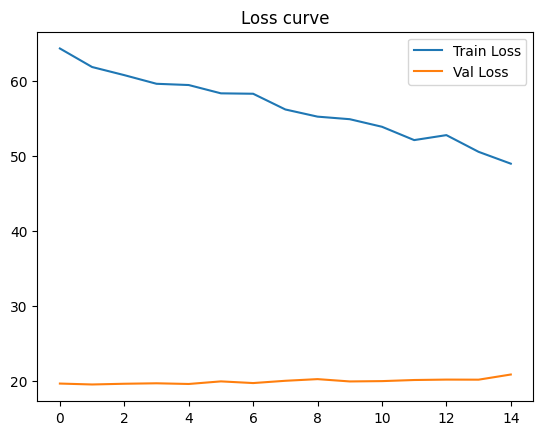

Validation metrics:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.33      0.35      0.34        26
           2       0.42      0.74      0.54        57
           3       0.69      0.47      0.56        62
           4       0.30      0.45      0.36        64
           5       0.00      0.00      0.00         9
           6       0.53      0.60      0.56        42
           7       0.00      0.00      0.00         6
           8       0.44      0.62      0.52        64
           9       0.00      0.00      0.00        11
          10       0.00      0.00      0.00         5
          11       0.51      0.72      0.60        47
          12       0.00      0.00      0.00         8
          13       0.14      0.22      0.17        18
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         7
          16       0.00      0.00      0.00        14
       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.title("Loss curve")
plt.legend()
plt.show()

print("Validation metrics:")
print(classification_report(y_true, y_pred))